# Derive and use gated likelihood

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from tqdm import tqdm
from numpy.fft import rfft, irfft

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import ESAOrbits, EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_p_at_t
from few.utils.fdutils import *
traj_module = EMRIInspiral(func="KerrEccEqFlux")

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from eryn.backends import HDFBackend

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
#Tobs = 1  # [years]
#dt = 50.0  # [s]

Tobs = 0.006 # almost 2 days [yrs]
dt = 10.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
#p0 = 8.2  # initial semi-latus rectum
p0 = 5.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        #t0 = 10000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

Generate TD data with detector response --> chans

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=False,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

#### Generate TD waveform

In [8]:
# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 10.48 s


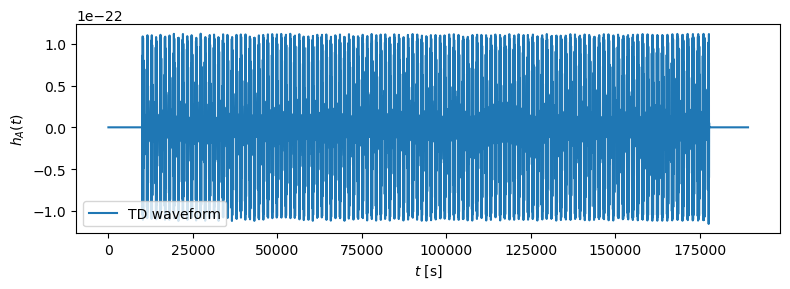

In [9]:
# Visualise the signal
time_array = np.arange(0,len(chans[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans[0], label='TD waveform')
plt.ylabel(r'$h_{A}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(1.7e5,1.9e5)
plt.legend()
plt.tight_layout()

plt.show()

#### Transform in FD and cut the data above minimum frequency

Compute min frequency

In [10]:
# Compute f_min
r_apo = p0 * M * MTSUN_SI / (1 - e0)  # meters
r_per = p0 * M * MTSUN_SI / (1 + e0)  # meters
r0 = (r_apo+r_per)/2

f_orb_0 = np.sqrt(M * MTSUN_SI / r0**3) / (2 * np.pi)  # rad/s

f_min = 2 * f_orb_0

Cut data above min freq

In [11]:
N = len(chans[0])
freqs = np.fft.rfftfreq(N, d=dt)       
complete_data = np.fft.rfft(chans, axis=-1) * dt  # FD

# No cut (I do this because it's quicker than changing the variable name everywhere)
data_filtered = complete_data
freq_filtered = freqs

#### Define w and W (gated function)

Choose positions of gaps: at 20%, 40%... of signal

In [12]:
N_d = 2*int(60*60/dt)   # Length gap: 2 hrs
#N_d = 2*int(60*60*24/dt)  # Length gap: 2 day

N_tot = len(chans[0])   # Tot lenght of signal

u = np.array([0.20, 0.40, 0.60, 0.80])  # position of gaps (after 20%, 40%... of signal)

idx = np.floor(u * (N_tot - N_d) - 1).astype(int) # obtain the indeces of such positions

Create w as an array of ones, where I put to zero the entries that correspond to the gaps

In [13]:
w = np.ones(N_tot, dtype=int)  
for i in idx: w[i:i+N_d] = 0     

Dataset with gaps obtained by multiplying the waveform by w (which sets the gap portions of the signal to zero)

In [14]:
chans_gap = chans * w

W diagonal matrix with w as its diagonal

In [15]:
W = np.diag(w)

Visualise signal with gaps

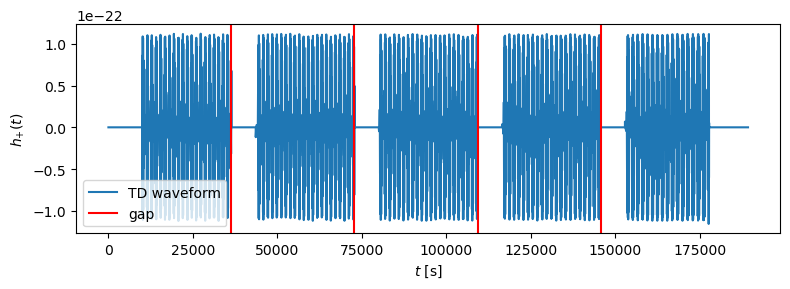

In [16]:
time_array = np.arange(0,len(chans_gap[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans_gap[0], label='TD waveform')
plt.axvline(idx[0]*dt, color='r', label='gap')
plt.axvline(idx[1]*dt, color='r')
plt.axvline(idx[2]*dt, color='r')
plt.axvline(idx[3]*dt, color='r')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()

### Visualise FD signal

In [17]:
fft_gated = np.fft.rfft(chans_gap[0]) * dt
freq_gated = np.fft.rfftfreq(len(chans_gap[0]), dt)

positive_frequency_mask_gated = (freq_gated > 0.0)

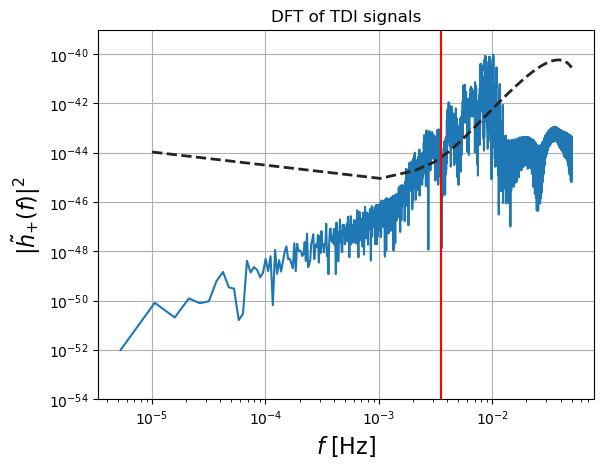

In [18]:
extr_freq_a = 1e-5
extr_freq_b = 5e-2
freq_grid = np.linspace(extr_freq_a, extr_freq_b)

plt.loglog(freq_gated[positive_frequency_mask_gated],
                 4 * freq_gated[positive_frequency_mask_gated]**2 * np.abs(fft_gated[positive_frequency_mask_gated])**2)
plt.loglog(freq_grid, get_sensitivity(freq_grid, sens_fn='A1TDISens', return_type='PSD')*freq_grid,
             color='#272323', linestyle='--', linewidth=2,   label='A/E ch. sens')
plt.axvline(f_min, c='r')
plt.ylabel(r'$| \tilde{h}_{+} (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.ylim([1e-54, 1e-39])
plt.title('DFT of TDI signals')
plt.show()

# FD likelihood 

### Compute pseudoinverse of gated covariance in FD

I'm doing everything for one channel (A). If it works, then I'll add also the second channel in the computation of the likelihood.

First, I compute Sigma tilda as a diagonal matrix with diagonal entries obtained by:

$$ \tilde{\Sigma}_{ii} = \frac{S_{n,i}}{2 df}  $$

So, first I take the corresponding frequencies.

In [19]:
N = len(W)
df = 1.0 / (N * dt)

# obtain all the positive frequencies corresponding to the signal
freqs = np.fft.rfftfreq(N, d=dt)

Then I compute the PSD for those frequencies and I build sigma tilde following the formula

In [20]:
Sn = get_sensitivity(freqs, sens_fn="A1TDISens") # Compute PSD

Sigma_tilde_diag = Sn / (2 * df) # Compute sigma tilde diagonal
Sigma_tilde = np.diag(Sigma_tilde_diag) # Create sigma tilde as a diagonal matrix from Sigma_tilde_diag
                                
print(Sigma_tilde)

[[9.46700000e+14 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.63091040e-34 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.08276067e-35 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.38003136e-35
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.37536515e-35 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.37069978e-35]]


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


Then, compute W_tilde as a diagonal matrix with the DFT of w as its diagonal.

In [21]:
w_tilde = np.fft.rfft(w) * dt  # DFT of w

W_tilde = np.diag(w_tilde) # W with w_tilde as its diagonal

print(f"W_tilde_filt shape: {W_tilde.shape}")
print(f"Sigma_tilde_filt shape: {Sigma_tilde.shape}")

W_tilde_filt shape: (9468, 9468)
Sigma_tilde_filt shape: (9468, 9468)


Compute $(\tilde{W}\tilde{\Sigma}\tilde{W})$.

In [22]:
Sigma_tilde_gated = W_tilde @ Sigma_tilde @ W_tilde

Now compute the pseudoinverse with $\texttt{np.linalg.pinv}$ and save it in a file, because the computation is a bit long (400 s).

In [23]:
pinv_computation = True

pinv_filename = "noCut_pinv_Sigma_tilde_gated.npy"

if pinv_computation:
    # Compute pseudoinverse
    start = time.time()
    pinv_Sigma_tilde_gated = np.linalg.pinv(Sigma_tilde_gated)
    print(f"Pseudoinverse computation took {time.time()-start:.2f} s")
    
    # Save result
    np.save(pinv_filename, pinv_Sigma_tilde_gated)
    print(f"Pseudoinverse saved to {pinv_filename}")
else:
    # Load pseudoinverse from file
    print(f"Loading pseudoinverse from {pinv_filename}")
    pinv_Sigma_tilde_gated = np.load(pinv_filename)
    print(f"Pseudoinverse loaded successfully")

Pseudoinverse computation took 469.54 s
Pseudoinverse saved to noCut_pinv_Sigma_tilde_gated.npy


I see that pinv_Sigma_filt is complex. How big is the imaginary part?

In [24]:
max_imag = np.max(np.abs(np.imag(pinv_Sigma_tilde_gated)))
print("Max imaginary part:", max_imag)

Max imaginary part: 0.0


It's big.

### Define likelihood function in FD

Define the function for h (template), which does everything I did to generate and cut my FD dataset (without gaps).

In [25]:
def signal_gen(*emri_waveform_args):
    chans = fastlisaresponse(*emri_waveform_args, emri_waveform_kwargs=emri_waveform_kwargs)
    
    FD_templ = np.fft.rfft(chans, axis=-1) * dt 
    
    return FD_templ

Define function to compute the residuals ($\tilde{Wd}-\tilde{h}$), as presented in Eq.52 of Burke+(2025) paper:
- I apply W to d, obtaining the gapped TD dataset.
- Then I transform it in FD and CUT IT.
- Finally I subtract the template h.

In [26]:
def residual_computation(d, W, h):
    # Args:
    # d = TD dataset
    # W = gated function
    # h = FD template (already cut)
    
    gated_data = W @ d
    
    FD_data = np.fft.rfft(gated_data) * dt 
    
    return FD_data - h

Define the likelihood function as in Eq.52 of Burke+(2025) paper.

In [27]:
def log_likelihood(d, *emri_waveform_args, pinv_Sigma=pinv_Sigma_tilde_gated):
    """
    Compute the gated log-likelihood presented in Eq.52 of Burke+(2025) paper.
    where `h` is produced by `signal_gen(*emri_waveform_args)`.

    Args:
        d: Observed data. 
        *emri_waveform_args: Arguments passed directly to `signal_gen` in order to 
            generate the waveform model `h(theta)`.
        pinv_Sigma: pseudoinverse of FD covariance matrix.

    Returns:
        float or complex: Value of the log-likelihood. Returns a real scalar by
            default, or complex if `complex=True` is passed in `inner_kwargs`.
    """
    
    h = signal_gen(*emri_waveform_args)

    r = residual_computation(d[0], W, h[0])

    return -0.5 * np.conj(r).T @ pinv_Sigma @ r

In [28]:
log_likelihood(chans, *emri_waveform_args)

np.complex128(-5.683584521907597e-68+0j)

In [29]:
max_imag = np.max(np.abs(np.imag(log_likelihood(chans, *emri_waveform_args))))
print("Max imaginary part:", max_imag)

Max imaginary part: 0.0


### Evaluate the likelihood to check

I also plot the imaginary part, just to check.

In [30]:
M_grid = np.linspace(9e5, 1.1e6, 11)

real_logL = -1 * np.ones(len(M_grid))
imag_logL = -1 * np.ones(len(M_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)

for idx, M in tqdm(enumerate(M_grid), total=len(M_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    
    ll = log_likelihood(chans, *emri_waveform_args_M)
    real_logL[idx] = np.real(ll)
    imag_logL[idx] = np.imag(ll)


python(26684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
M grid: 100%|█████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.13s/it]


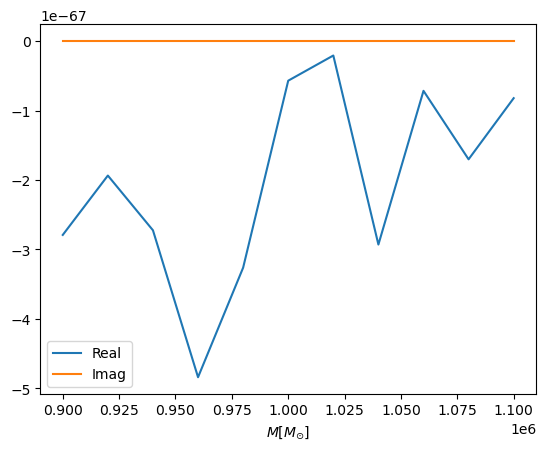

In [31]:
plt.plot(M_grid, real_logL, label='Real')
plt.plot(M_grid, imag_logL, label='Imag')

plt.xlabel(r'$M [M_{\odot}]$')
plt.legend()
plt.show()

In [32]:
max_idx = np.argmax(real_logL)
M_best = M_grid[max_idx]
logL_max = real_logL[max_idx]

print(f"Best M: {M_best:.2e}")

Best M: 1.02e+06


### Try and vary mu

In [33]:
mu_grid = np.linspace(9.9, 10.1, 11)

real_logL = -1 * np.ones(len(M_grid))
imag_logL = -1 * np.ones(len(M_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
M=1e6
for idx, mu in tqdm(enumerate(mu_grid), total=len(mu_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]
    
    ll = log_likelihood(chans, *emri_waveform_args_M)
    real_logL[idx] = np.real(ll)
    imag_logL[idx] = np.imag(ll)


M grid: 100%|█████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.19s/it]


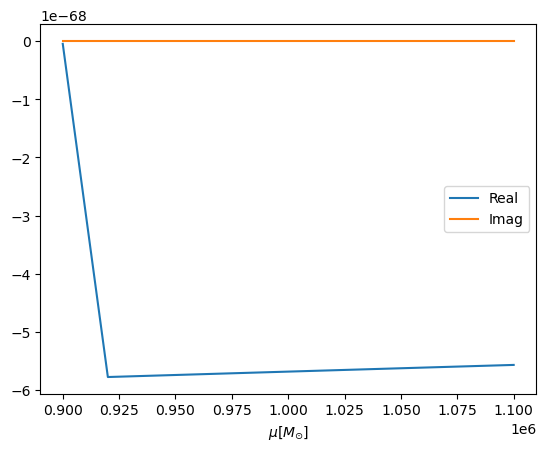

In [34]:
plt.plot(M_grid, real_logL, label='Real')
plt.plot(M_grid, imag_logL, label='Imag')

plt.xlabel(r'$\mu [M_{\odot}]$')
plt.legend()
plt.show()

In [35]:
max_idx = np.argmax(real_logL)
mu_best = mu_grid[max_idx]
logL_max = real_logL[max_idx]

print(f"Best mu: {mu_best:.2e}")

Best mu: 9.90e+00


# MCMC

In [36]:
def wrapper_likelihood(x, fixed_parameters, d=chans):
    # Only M and mu vary, others are fixed
    params = [x[0], x[1]] + fixed_parameters.tolist()
    return log_likelihood(d, *params)

In [37]:
priors = {'emri': ProbDistContainer({
    0: uniform_dist(9.999e5, 1.001e6),
    1: uniform_dist(9.99, 10.01)
}, return_gpu=use_gpu)}


fixed_parameters = np.array([
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
])

In [38]:
fname = "FD_gated_likelihood.h5"
if os.path.exists(fname):
    ts = datetime.datetime.now().strftime("_%Y%m%d_%H%M%S")
    os.rename(fname, fname.replace(".h5", ts + ".h5"))
backend = HDFBackend(fname)

Backup